In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0)\
{ jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();\
">Toggle code</button>''', raw=True)

Toggle code

In [2]:
import pyemma
import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pyemma.coordinates as coor
import sys
%matplotlib inline
import pyemma.msm as msm
import pyemma.plots as mpl
import my_tools as my
import readwrite as rw
import cPickle as pickle
from scipy.spatial import distance
import gvec_func as gv
import pvec_func as pv
import dihedrals_func as dih

# 1 - Discretization

In [3]:
# input files definitions
directo='/u/sbp/srnas1/giopina/run_GROMACS/trino/'
trajfiles=[directo+'run2/align.xtc']
for idir in range(1,5):
    for irun in range(4):
        trajfiles.append(directo+'run_vari/dir'+str(idir)+'/run'+str(irun)+'/align_'+str(idir)+'_'+str(irun)+'.xtc')
topfile=directo+'setup/setup.gro'

In [4]:
feat_dGP=coor.featurizer(topfile)
nres=3

feat_dGP.add_custom_func(gv.get_gvecs,4*nres*nres)
top=feat_dGP.topology
lista_dihedrals=dih.get_dihedrals_ndx(top)
for ll in lista_dihedrals:
    feat_dGP.add_dihedrals(ll,cossin=True,periodic=False)
lista_pucker=dih.get_pucker_ndx(top)
for ll in lista_pucker:
    feat_dGP.add_dihedrals(ll,cossin=True,periodic=False)
lista_chis=dih.get_chi_ndx(top)
feat_dGP.add_dihedrals(lista_chis,cossin=True,periodic=False)

inp_dGP = coor.source(trajfiles, feat_dGP)

Obtaining file info: 100% (17/17) [################################] eta 00:01 /

In [5]:
# Files for output structures
featXout=coor.featurizer(topfile)
featXout.add_all()
inpXout = coor.source(trajfiles, featXout)

Obtaining file info: 100% (17/17) [################################] eta 00:00 -

In [6]:
print 'N. trajectories =',inp_dGP.ntraj
print 'N. frames =',inp_dGP.n_frames_total()
print 'Total length =',inp_dGP.n_frames_total()/10000., 'microseconds'
#print 
#print 'Ideal number of microstates =',np.sqrt(inp_dGP.n_frames_total())

N. trajectories = 17
N. frames = 570677
Total length = 57.0677 microseconds


## 1.1 - TICA analysis:

In [7]:
#traj=coor.load(trajfiles,feat_dGP,chunk_size=1000)

In [8]:
#tica_obj=coor.tica(traj,50)
#tica_traj=tica_obj.get_output()
#tica_dim,cumvar=my.get_tica_cumvar(tica_obj)
#print 'dimension=%d' %tica_dim
#rw.write_tica_eval('dGnew2_lt50',tica_obj)
#rw.write_tica_evec('dGnew2_lt50',tica_obj)
#rw.write_tica_trajs('dGnew2_lt50',tica_traj)

In [7]:
dire='/u/sbp/srnas2/giopina/markov/trino/'
tica_eval=rw.read_tica_eval(dire+'dGPnew2_lt50')
tica_evec=rw.read_tica_evec(dire+'dGPnew2_lt50')
tica_traj=rw.read_tica_trajs(dire+'dGPnew2_lt50',inp_dGP.ntraj)
tica_dim=tica_traj[0].shape[1]
print tica_dim

19


##  1.2 - Clustering:

In [10]:
# Clustering with k-means
#%time cl = coor.cluster_kmeans(data=[X[:,0:tica_dim] for X in tica_traj],\
#                               k=100,stride=1,max_iter=50,fixed_seed=True)
#dtrajs = cl.assign(stride=1)
#cl_centers=cl.clustercenters
#rw.write_cl_dtrajs('dGnew2_lt50_k100',dtrajs)
#rw.write_cl_centers('dGnew2_lt50_k100',cl)
#rw.write_cl_indexes('dGnew2_lt50_k100',cl)

In [16]:
cl_centers=rw.read_cl_centers(dire+'dGnew2_lt50_k100')
dtrajs=rw.read_cl_dtrajs(dire+'dGnew2_lt50_k100',inp_dGP.ntraj)

In [14]:
Ytot=tica_traj[0]
for i in range(1,len(tica_traj)):
    Ytot=np.concatenate((Ytot,tica_traj[i]))
ix=0
iy=1
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F01 = -np.log(z)
extent01 = [x[0], x[-1], y[0], y[-1]]
ix=2
iy=1
z,x,y = np.histogram2d(Ytot[:,ix],Ytot[:,iy], bins=100)
F21 = -np.log(z)
del Ytot
extent21 = [x[0], x[-1], y[0], y[-1]]

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log


## 1.3 - Implied timescales:

In [12]:
### Implied timescales
its=msm.its(dtrajs,lags=[1,5,10,20,30,40,50,60,80,100,120,150,200,250,300,400],nits=15)

estimating MaximumLikelihoodMSM: 100% (16/16) [####################] eta 00:01 \

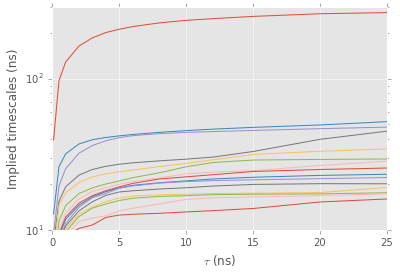

In [16]:
#plt.figure(figsize=(10,7))
with plt.style.context(('ggplot')):
    plt.plot(its.lags/10.,its.timescales/10.,lw=1.)
#plt.plot(its.lags/10.,its.lags/10.,lw=3,c='black')
    plt.ylim(10,300)
    plt.xlim(0,25)
    plt.yscale('log')
    plt.ylabel('Implied timescales (ns)')
    plt.xlabel(r'$\tau$ (ns)')
    dire='/u/sbp/giopina/Dropbox/SISSA/markov/trino/'
    name='trino-its'
    for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

In [23]:
rw.write_msm_its(dire+'dGnew2_lt50_k100',its)

# 2 - Markov state model construction and analysis

In [19]:
M=msm.estimate_markov_model(dtrajs,50)
rw.write_msm(dire+'dGnew2_lt50_k100_lm50',M)

In [454]:
M.active_state_fraction

1.0

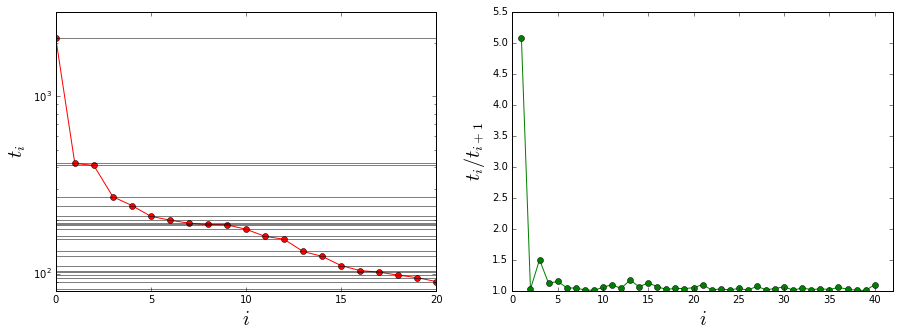

In [20]:
plt.figure(figsize=(15,5))
plt.subplot2grid((1,2),(0,0))
### Eigenvalues plot
plt.plot(M.timescales()[:22],marker='o', color='red')
plt.plot([0,21],[80,80])
for ts in M.timescales()[:22]:
    plt.plot([0,21],[ts,ts],c='black',lw=0.5)
plt.yscale('log')
plt.ylim(80,3000)
plt.xlim(0,20)
plt.ylabel('$t_i$',fontsize=20)
plt.xlabel('$i$',fontsize=20)
plt.subplot2grid((1,2),(0,1))
plt.plot(range(1,41),M.timescales()[0:40]/M.timescales()[1:41],marker='o',color='green')
plt.xlabel('$i$',fontsize=20)
plt.xlim(0,42)
plt.ylabel('$t_i / t_{i+1}$',fontsize=20)

In [17]:
BM=msm.bayesian_markov_model(dtrajs,50)
bm_timescales_std=BM.sample_std('timescales')

Sampling MSMs: 100% (100/100) [####################################] eta 00:00 |

In [18]:
print 'MSM timescales:'
for i in range(7):
    print('%3.f +/- %2.f ns' % (M.timescales()[i]/10,bm_timescales_std[i]/10*np.sqrt(3)) )

MSM timescales:
212 +/-  8 ns
 42 +/-  2 ns
 41 +/-  2 ns
 27 +/-  2 ns
 24 +/-  2 ns
 21 +/-  2 ns
 20 +/-  2 ns


The model identify a very slow process ($t\simeq200$ ns). The fastest processes are dominated by two timescales around $40$ ns

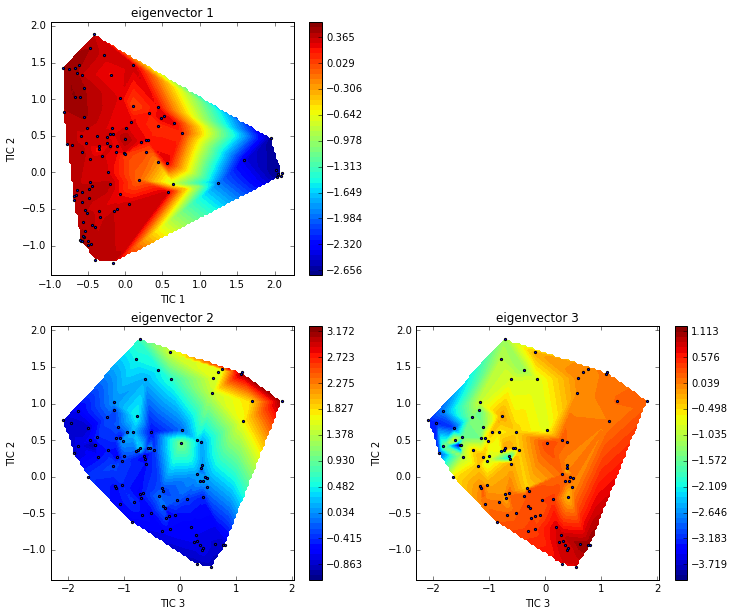

In [36]:
cl_centers=cl.clustercenters
plt.figure(figsize=(12,10))
plt.subplot2grid((2,2),(0,0))
icomp=1
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,0], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 2');plt.xlabel('TIC 1')
plt.subplot2grid((2,2),(1,0))
icomp=2
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,2], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 2');plt.xlabel('TIC 3')
plt.subplot2grid((2,2),(1,1))
icomp=3
r2 = M.eigenvectors_right()[:,icomp]
mpl.scatter_contour(cl_centers[M.active_set,2], cl_centers[M.active_set,1], r2)
plt.title('eigenvector '+str(icomp))
plt.ylabel('TIC 2');plt.xlabel('TIC 3')

## 2.1 - Coarse graining the MSM with an hidden Markov model

In [8]:
colors=np.array(['blue','red','green','gold'])

In [11]:
#HMM4=M.coarse_grain(4)
#rw.write_hmm('dGnew2_lt50_k100_lm50',HMM4)
HMM4=rw.read_hmm(dire+'dGnew2_lt50_k100_lm50')
nstates=4

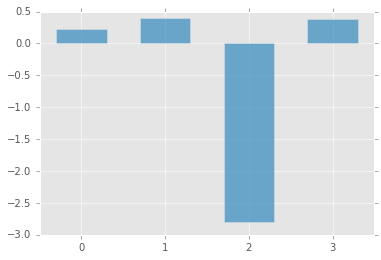

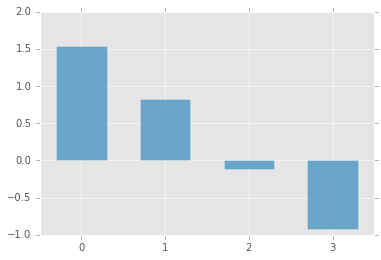

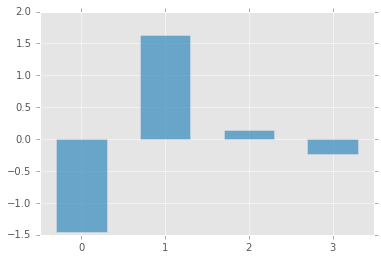

In [12]:
for icomp in range(1,nstates):
    plt.figure()
    #plt.plot(HMM6.eigenvectors_right()[:,icomp],ls='',marker='d')
    with plt.style.context(('ggplot')):
        plt.bar(np.array(range(nstates))-0.3,\
                HMM4.eigenvectors_right()[:,icomp],width=0.6,alpha=0.7)
        #plt.plot([-1,4],[0,0],color='black',lw=1,ls=':',alpha=0.5)
        plt.xlim(-0.5,3.5)
        plt.xticks(range(0,nstates))

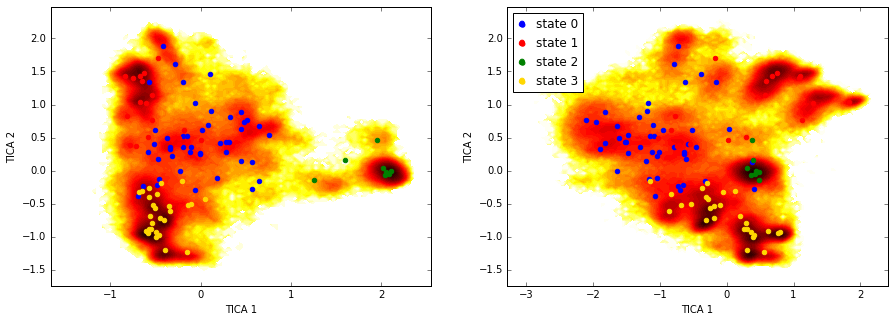

In [17]:
### HMM metastable states, projected on the first 2 TICs, with the density plot from the trajectories
# NB: trajectories NOT completely at equlibrium, so density plot is only for visualization 
#     does not correspond to the true distribution

fig = plt.figure(figsize=(15,5))
plt.subplot2grid((1,2),(0,0))
ix=0
iy=1
pcca_sets = HMM4.metastable_sets
plt.contourf(F01.T, 50, cmap=plt.cm.hot, extent=extent01)
for ipcca in range(len(pcca_sets)):
    plt.scatter(cl_centers[pcca_sets[ipcca],ix], cl_centers[pcca_sets[ipcca],iy]\
                , color=colors[ipcca],label='state '+str(ipcca))
plt.ylabel('TICA 2')
plt.xlabel('TICA 1')
plt.subplot2grid((1,2),(0,1))
ix=2
iy=1
pcca_sets = HMM4.metastable_sets
plt.contourf(F21.T, 50, cmap=plt.cm.hot, extent=extent21)
for ipcca in range(len(pcca_sets)):
    plt.scatter(cl_centers[pcca_sets[ipcca],ix], cl_centers[pcca_sets[ipcca],iy]\
                , color=colors[ipcca],label='state '+str(ipcca))
plt.ylabel('TICA 2')
plt.xlabel('TICA 1')
plt.legend(loc=2,numpoints=1,handlelength=0.7)

In [20]:
#nstates=len(pcca_sets)
hmm_dist = HMM4.metastable_distributions
hmm_samples = M.sample_by_distributions(hmm_dist, 1000)
outfiles = ['dGnew2_hmm'+str(i)+'_'+str(nstates)+'ms.pdb' for i in range(0,nstates)]
coor.save_trajs(inpXout, hmm_samples, outfiles=outfiles)

16-09-16 10:34:58 pyemma.coordinates.api INFO     Created file dGnew2_hmm0_4ms.pdb
16-09-16 10:35:04 pyemma.coordinates.api INFO     Created file dGnew2_hmm1_4ms.pdb
16-09-16 10:35:09 pyemma.coordinates.api INFO     Created file dGnew2_hmm2_4ms.pdb
16-09-16 10:35:14 pyemma.coordinates.api INFO     Created file dGnew2_hmm3_4ms.pdb


['dGnew2_hmm0_4ms.pdb',
 'dGnew2_hmm1_4ms.pdb',
 'dGnew2_hmm2_4ms.pdb',
 'dGnew2_hmm3_4ms.pdb']

In [21]:
BHMM=msm.bayesian_hidden_markov_model(dtrajs,4,50)

/u/sbp/giopina/software/miniconda/lib/python2.7/site-packages/msmtools/analysis/dense/decomposition.py:530: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


Sampling HMSMs: 100% (100/100) [###################################] eta 00:00 /

In [22]:
bhmm_statdist_mean=BHMM.sample_mean('stationary_distribution')
bhmm_statdist_std=BHMM.sample_std('stationary_distribution')
bhmm_statdist_conf=BHMM.sample_conf('stationary_distribution')

In [23]:
bhmm_timescales_mean=BHMM.sample_mean('timescales')
bhmm_timescales_std=BHMM.sample_std('timescales')
bhmm_timescales_conf=BHMM.sample_conf('timescales')

In [24]:
i=0
print '#state | population'
for x in HMM4.stationary_distribution:
    print '  %d        %2.f +/- %1.f%%'% (i,x*100,np.sqrt(3)*bhmm_statdist_std[i]*100)
    i+=1

#state | population
  0        18 +/- 2%
  1        22 +/- 3%
  2        11 +/- 5%
  3        48 +/- 5%


In [25]:
print ' *** Timescales (ns)*** '
print 'idx |     MSM    |     HMM'
for i in range(3):
    print ' %d    %3.f +/- %2.f    %3.f +/- %2.f'\
    % (i,M.timescales()[i]/10,0,HMM4.timescales()[i]/10,bhmm_timescales_std[i]/10*np.sqrt(3))



 *** Timescales (ns)*** 
idx |     MSM    |     HMM
 0    212 +/-  0    295 +/- 95
 1     42 +/-  0     41 +/-  4
 2     41 +/-  0     39 +/-  4


In [23]:
states_pos=np.array([\
            np.sum(cl_centers[:,:2]*HMM4.metastable_distributions[istate][:,np.newaxis],axis=0)\
            for istate in range(4)])

In [24]:
from scipy.linalg import logm
hmm_rate_matrix=logm(HMM4.transition_matrix)

In [25]:
HMM4.transition_matrix

array([[  9.04900937e-01,   3.07233736e-02,   6.16835876e-03,
          5.82073308e-02],
       [  2.48886336e-02,   9.11078282e-01,   2.64932903e-04,
          6.37681514e-02],
       [  9.87092123e-03,   5.23349493e-04,   9.84734774e-01,
          4.87095502e-03],
       [  2.16818850e-02,   2.93218270e-02,   1.13382339e-03,
          9.47862465e-01]])

In [26]:
hmm_rate_matrix2=hmm_rate_matrix/HMM4.lagtime*10*1e3
hmm_rate_matrix2[np.abs(hmm_rate_matrix2)<1e-1]=0.0

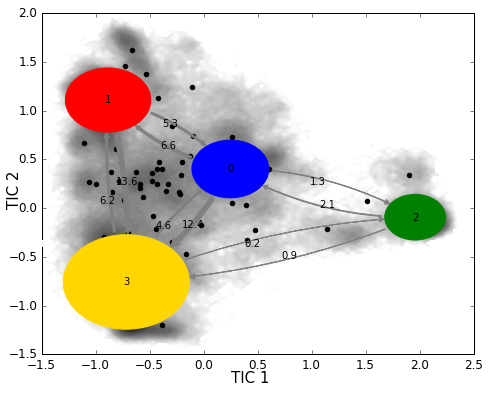

In [29]:
my_pos=np.array(states_pos)
my_pos[0]+=np.array([0.4,-0.1])
my_pos[1]+=np.array([0.,0.2])
plt.contourf(F01.T, 50, cmap=plt.cm.Greys_r, extent=extent01,zorder=-1)
#plt.contourf(F01.T, 50, cmap=plt.cm.PuBu_r, extent=extent01,zorder=-1)
#plt.contourf(F01.T, 50, cmap=plt.cm.bone, extent=extent01,zorder=-1)
#plt.contourf(F01.T, 50, cmap=plt.cm.pink, extent=extent01,zorder=-1)
#plt.contourf(F01.T, 50, cmap=plt.cm.Purples_r, extent=extent01,zorder=-1)
plt.ylabel('TIC 2',fontsize=15)
plt.xlabel('TIC 1',fontsize=15)
plt.scatter(cl_centers[:,0],cl_centers[:,1],color='black',zorder=0)
fff,ppp=mpl.plot_network(hmm_rate_matrix2,pos=my_pos,state_colors=colors,\
                     state_sizes=HMM4.stationary_distribution,arrow_label_format='%1.1f',\
                        max_width=8,state_scale=3)
plt.ylim(-1.7,2.3)
plt.xlim(-1.3,2.5)
bckax=fff.add_axes([0.15,0.15,0.75,0.75],zorder=-1)
#cacca=bckax.xaxis.set_ticks(np.arange(-1.7,2.3,0.5))
#cacca=bckax.yaxis.set_ticks(np.arange(-1.3,2.5,0.5))
plt.xticks(np.arange(-1.5,3.0,0.5),fontsize=12)
plt.yticks(np.arange(-1.5,2.5,0.5),fontsize=12)

dire='/u/sbp/giopina/Dropbox/SISSA/markov/trino/'
name='trino-schema-new'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200) 

# 3 -HMM's metastable states analysis

In [21]:
nstates=HMM4.nstates
### reading structures:
trajfiles_meta_states=['dGnew2_hmm'+str(i)+'_'+str(nstates)+'ms.xtc' \
            for i in range(nstates)]

## 3.1 Dihedrals

In [34]:
feat_dih=coor.featurizer(topfile)
top=feat_dih.topology
lista_dihedrals=dih.get_dihedrals_ndx(top)
for ll in lista_dihedrals:
    feat_dih.add_dihedrals(ll,cossin=False)
lista_pucker=dih.get_pucker_ndx(top)
for ll in lista_pucker:
    feat_dih.add_dihedrals(ll,cossin=False)
lista_chis=dih.get_chi_ndx(top)
feat_dih.add_dihedrals(lista_chis,cossin=False)

In [230]:
### cmomputing observables
dih_meta_states=np.array(coor.load(trajfiles_meta_states,feat_dih))

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 |

In [47]:
stat_dist = M.stationary_distribution
stat_samples = M.sample_by_distributions([stat_dist], 1000)
trajfiles_statdist=['dGnew2_statdist.xtc']
#coor.save_trajs(inpXout, stat_samples, outfiles=trajfiles_statdist)
### cmomputing observables
dih_statdist=np.array(coor.load(trajfiles_statdist,feat_dih))

In [48]:
dih_names=[]
for lll,name in zip(lista_dihedrals,[r'$\alpha',r'$\beta',r'$\gamma',r'$\delta',r'$\epsilon',r'$\zeta']):
    for i in range(len(lll)):
        if name==r'$\alpha' or name==r'$\beta':
            dih_names.append(name+'_'+str(i+2)+'$')
        else:
            dih_names.append(name+'_'+str(i+1)+'$')
for lll,name in zip(lista_pucker,[r'$\nu^0',r'$\nu^1',r'$\nu^2',r'$\nu^3',r'$\nu^4']):
    for i in range(len(lll)):
        dih_names.append(name+'_'+str(i+1)+'$')
lll=lista_chis
name=r'$\chi'
for i in range(len(lll)):
    dih_names.append(name+'_'+str(i+1)+'$')
print len(dih_names), 'dihedrals'

32 dihedrals


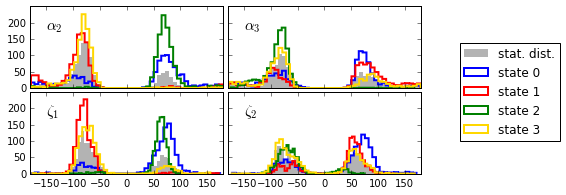

In [279]:
#8.27 in × 11.7
iplot=0
fig, axes = plt.subplots(2,2, \
        #gridspec_kw = {'width_ratios':[1.05]+[1 for x in range(nevec)]+[0.05]},\
        figsize=(7,3.),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
for i_dih in[0,1]:
    ax=axes[0,iplot]
    ax.text(-150,180,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,normed=False,\
                label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,\
                 histtype='step',lw=2,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate])
    ax.set_xlim(-180,180)
    ax.set_ylim(0,250)
    ax.yaxis.set_ticks(range(0,201,50))
    iplot+=1
    
iplot=0
for i_dih in[12,13]:
    ax=axes[1,iplot]
    ax.text(-150,180,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,normed=False,\
                 label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',\
                 lw=2,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate])
    iplot+=1
    ax.set_xlim(-180,180)
    ax.set_ylim(0,250)
    ax.yaxis.set_ticks(range(0,201,50))
plt.legend(loc=(1.2,0.4))
dire='/u/sbp/giopina/Dropbox/SISSA/markov/trino/'
name='trino-dih_alpha-zeta'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

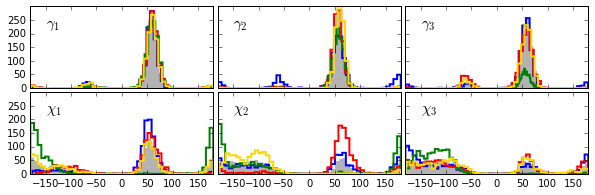

In [280]:
#8.27 in × 11.7
iplot=0
fig, axes = plt.subplots(2,3, \
        #gridspec_kw = {'width_ratios':[1.05]+[1 for x in range(nevec)]+[0.05]},\
        figsize=(10,3.),sharex=True,sharey=True)#,sharey=True,sharex=True)
plt.subplots_adjust(hspace=0.05,wspace=0.025)
for i_dih in[4,5,6]:
    ax=axes[0,iplot]
    ax.text(-150,250*0.9,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,normed=False,\
                label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,\
                 histtype='step',lw=2,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate])
    ax.set_xlim(-180,180)
    ax.set_ylim(0,300)
    ax.yaxis.set_ticks(range(0,251,50))
    iplot+=1
    
iplot=0
for i_dih in[29,30,31]:
    ax=axes[1,iplot]
    ax.text(-150,250*0.9,dih_names[i_dih],fontsize=15)
    ax.hist(dih_statdist[:,i_dih]*180/np.pi,lw=0,bins=50,normed=False,\
                 label='stat. dist.',facecolor='0.7')#,histtype='step')
    for istate in range(0,nstates):
        ax.hist(dih_meta_states[istate][:,i_dih]*180/np.pi,histtype='step',\
                 lw=2,bins=50,normed=False,\
                 label='state '+str(istate),color=colors[istate])
    iplot+=1
    ax.set_xlim(-180,180)
    ax.set_ylim(0,300)
    ax.yaxis.set_ticks(range(0,251,50))
    #plt.legend()
dire='/u/sbp/giopina/Dropbox/SISSA/markov/trino/'
name='trino-dih_gamma-chi'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight')     

## 3.2 - The hydrogen bond

In [231]:
feat_hb=coor.featurizer(topfile)
ndx1=feat_hb.select('name OP2 and resid 2')[0]
ndx2=feat_hb.select('name H5T and resid 0')[0]
print 'distances between:',[ndx1,ndx2]
feat_hb.add_distances([ndx1,ndx2])

#print 'N. of features:',feat_hb.dimension()
### cmomputing observables
hb_meta_states=np.array(coor.load(trajfiles_meta_states,feat_hb))
### cmomputing observables
hb_statdist=np.array(coor.load(trajfiles_statdist,feat_hb))

distances between: [66, 1]
14-07-16 16:18:35 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[8] WARNING  The 1D arrays input for add_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 |

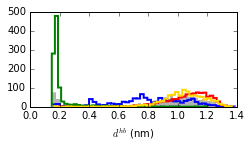

In [281]:
fig=plt.figure(figsize=(3.7,1.7))
#plt.title('dist A3:OP2 - A1:H5T',fontsize=15)
plt.hist(hb_statdist[:,0],lw=0,bins=50,normed=False,\
            label='stat. dist.',facecolor='0.7')#,histtype='step')
for istate in range(0,nstates):
    plt.hist(hb_meta_states[istate][:,0],histtype='step',lw=2,bins=50,normed=False,\
            label='state '+str(istate),color=colors[istate])
plt.xlabel(r'$d^{{hb}}$ (nm)')    
#plt.yscale('log')
dire='/u/sbp/giopina/Dropbox/SISSA/markov/trino/'
name='trino-dist_hb'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

STACKING
========

In [150]:
reload(stack)

<module 'stackdef' from '/u/sbp/giopina/Dropbox/SISSA/software/pyemma_shortcuts/stackdef.py'>

In [151]:
import stackdef as stack

feat_stack=coor.featurizer(topfile)
for i in range(3):
    for j in range(i+1,3):
        print 'stacking between:',i,j
        feat_stack.add_custom_func(stack.get_stack_score,1,i,j)
print 'N. of features:',feat_stack.dimension()

stacking between: 0 1
stacking between: 0 2
stacking between: 1 2
N. of features: 3


In [152]:
### cmomputing observables
stack_meta_states=np.array(coor.load(trajfiles_meta_states,feat_stack,chunk_size=500))

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 \

In [353]:
#print stack_meta_states
stack_percentages=[]
for istate in range(nstates):
    tmp_stack=[]
    for kres in range(3):
        print len(np.where(stack_meta_states[istate][:,kres]>0.1)[0])/10.,
        tmp_stack.append(len(np.where(stack_meta_states[istate][:,kres]>0.1)[0])/10.)
    stack_percentages.append(np.array(tmp_stack))
    print ''
stack_percentages=np.array(stack_percentages)

19.4 26.8 22.1 
31.1 14.5 45.4 
0.2 98.1 53.4 
56.4 0.4 57.0 


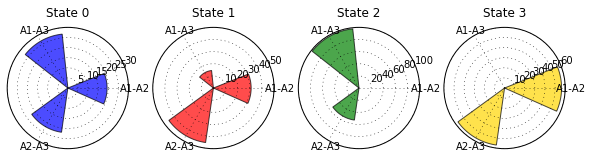

In [396]:
f,axs = plt.subplots(1,4,subplot_kw=dict(projection='polar'),figsize=(10,4))
f.subplots_adjust(wspace=0.2)
for istate in range(nstates):
    ax=axs[istate]
    ax.bar([(x-0.2)*np.pi/3*2 for x in range(3)],stack_percentages[istate],\
           label='state '+str(istate),color=colors[istate],alpha=0.7)
    cacca=ax.set_xticks([x*2*np.pi/3 for x in range(3)])
    labs=[]
    for ires in range(3):
        for jres in range(ires+1,3):
            labs.append('A%s-A%s' % (ires+1,jres+1))
    cacca=ax.set_xticklabels(labs)#,rotation=60)
    ax.set_title('State '+str(istate),fontsize=12)
#cacca=ax.set_yticklabels([])
#plt.legend(loc=(1.2,0.2))
dire='/u/sbp/giopina/Dropbox/SISSA/markov/trino/'
name='trino-stacking'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

## 3.5 G-vectors

In [398]:
var_names=[]
### G-VECTORS
nres=3
for ires in range(nres):
    for jres in range(nres):
        for mu in ['x','y','z','t']:
            var_names.append('$(G_{'+str(ires+1)+' '+str(jres+1)+'})_'+mu+'$')            
### BACKBONE DIHEDRALS
for lll,name in zip(lista_dihedrals,[r'\alpha',r'\beta',r'\gamma',r'\delta',r'\epsilon',r'\zeta']):
    for i in range(len(lll)):
        if name=='\alpha' or name=='\beta':
            var_names.append(r'$\cos('+name+'_'+str(i+2)+')$')
            var_names.append(r'$\sin('+name+'_'+str(i+2)+')$')
        else:
            var_names.append(r'$\cos('+name+'_'+str(i+1)+')$')
            var_names.append(r'$\sin('+name+'_'+str(i+1)+')$')
### PUCKERING ANGLES
for lll,name in zip(lista_pucker,[r'\nu^0',r'\nu^1',r'\nu^2',r'\nu^3',r'\nu^4']):
    for i in range(len(lll)):
        var_names.append(r'$\cos('+name+'_'+str(i+1)+')$')
        var_names.append(r'$\sin('+name+'_'+str(i+1)+')$')
lll=lista_chis
name=r'\chi'
### CHI ANGLES
for i in range(len(lll)):
    var_names.append(r'$\cos('+name+'_'+str(i+1)+')$')
    var_names.append(r'$\sin('+name+'_'+str(i+1)+')$')

In [399]:
feat_G=coor.featurizer(topfile)
nres=3
feat_G.add_custom_func(gv.get_gvecs,4*nres*nres)
inp_G = coor.source(trajfiles, feat_G)

Obtaining file info: 100% (17/17) [################################] eta 00:01 \

In [400]:
### cmomputing observables
gvec_meta_states=np.array(coor.load(trajfiles_meta_states,feat_G))

getting output of FeatureReader: 100% (4/4) [######################] eta 00:01 \

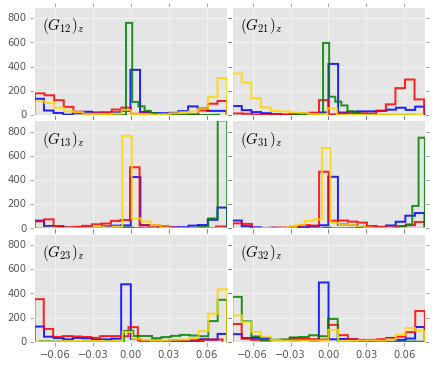

In [415]:
with plt.style.context(('ggplot')):
    fig, axes = plt.subplots(3,2, \
        figsize=(7,6),sharex=True,sharey=True)#,sharey=True,sharex=True)
    plt.subplots_adjust(hspace=0.05,wspace=0.025)
    kplt=0
    for kgkg in [[6,14],[10,26],[22,30]]:
        for k_gvec,iplt in zip(kgkg,[0,1]):
            ax=axes[kplt,iplt]
            for istate in range(nstates):            
                ax.hist(gvec_meta_states[istate][:,k_gvec],
                        bins=20,color=colors[istate],histtype='step',lw=2,\
                    label=str(istate),alpha=0.85)
            ax.text(-0.07,700,var_names[k_gvec],fontsize=15)
#            if iplt==0:
#                plt.ylabel('freq. (p.t.)',fontsize=15)
        kplt+=1
        ax.set_yticks(range(0,900,200))
        ax.set_xticks(np.arange(-0.06,0.07,0.03))
dire='/u/sbp/giopina/Dropbox/SISSA/markov/trino/'
name='trino-gvec'
for ext in ['.pdf','.png','.svg','.eps']:
        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

# 4 - Flux analysis

Analysis of the flux by means of transition path theory

In [264]:
flusso23=msm.tpt(M,HMM4.metastable_sets[2],HMM4.metastable_sets[3])
flusso32=msm.tpt(M,HMM4.metastable_sets[3],HMM4.metastable_sets[2])
CGsets32,CGflux32=flusso32.coarse_grain(HMM4.metastable_sets)
CGsets23,CGflux23=flusso23.coarse_grain(HMM4.metastable_sets)
CGpaths23,CGcaps23=CGflux23.pathways(fraction=0.95)
CGpaths32,CGcaps32=CGflux32.pathways(fraction=0.95)

In [265]:
for  ccc in CGsets23:
    print len(ccc)
print
for  ccc in HMM4.metastable_sets:
    print len(ccc)
print
for  ccc in CGsets32:
    print len(ccc)
print

8
46
18
28

46
18
8
28

28
46
18
8



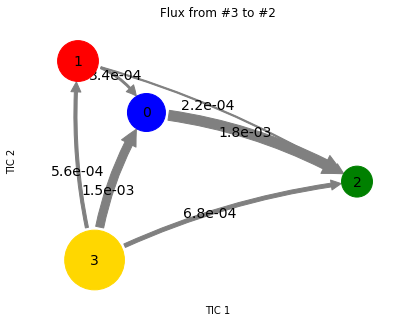

In [285]:
mpl.plot_flux(CGflux32,pos=states_pos[[3,0,1,2]],max_width=7,arrow_label_format='%2.1e',\
              state_labels=['3','0','1','2'],state_colors=colors[[3,0,1,2]])
plt.title('Flux from #3 to #2')
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')
ttt=plt.xticks([])

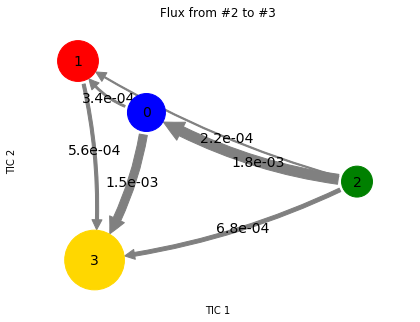

In [286]:
mpl.plot_flux(CGflux23,pos=states_pos[[2,0,1,3]],max_width=7,arrow_label_format='%2.1e',\
              state_labels=['2','0','1','3'],state_colors=colors[[2,0,1,3]])
plt.title('Flux from #2 to #3')
plt.xlabel('TIC 1')
plt.ylabel('TIC 2')
ttt=plt.xticks([])

Observation on the Transition Path Theory results:
1. The transition 3->2 goes through state #0 ~75% of the time (and viceversa)
2. ...

# Kinetics of stacking

In [155]:
inp_stack=coor.source(trajfiles,feat_stack,chunk_size=500)
%time traj_stack=coor.load(trajfiles,feat_stack,chunk_size=500)
avg_stack_cl=my.average_by_state(M,inp_stack,traj=traj_stack)

getting output of FeatureReader: 100% (17/17) [####################] eta 00:00 -CPU times: user 6min 23s, sys: 4 s, total: 6min 27s
Wall time: 6min 28s


In [363]:
reload(my)
#inp_stack=coor.source(trajfiles,feat_stack,chunk_size=500)
#%time traj_stack=coor.load(trajfiles,feat_stack,chunk_size=500)
std_stack_cl=my.std_by_state(M,inp_stack,traj=traj_stack)

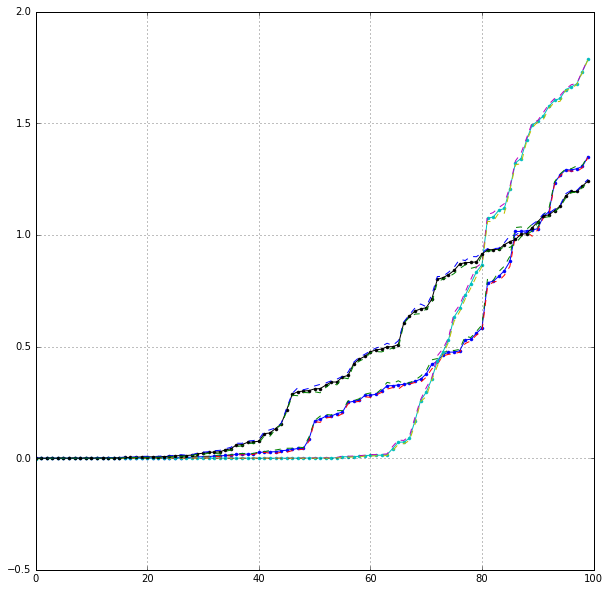

In [393]:
#istack=0
plt.figure(figsize=(10,10))
for istack in range(0,3,1):
    order=np.argsort(avg_stack_cl[:,istack])
    plt.plot(avg_stack_cl[order,istack],marker='.')
    plt.plot(avg_stack_cl[order,istack]+std_stack_cl[order,istack],ls='--')
    plt.plot(avg_stack_cl[order,istack]-std_stack_cl[order,istack],ls='--')
plt.grid()

In [386]:
stack_perc=np.zeros((M.nstates,3))
NN=np.zeros(M.nstates)
itraj=0
for dt in M.discrete_trajectories_active:
    for iframe in dt:        
        stack_perc[iframe,traj_stack[itraj][iframe]>0.6]+=1
        NN[iframe]+=1
    itraj+=1
stack_perc/=NN[:,np.newaxis]

(array([ 21.,  26.,  19.,  11.,  14.,   2.,   3.,   2.,   0.,   2.]),
 array([ 0.        ,  0.05179623,  0.10359246,  0.15538869,  0.20718492,
         0.25898115,  0.31077739,  0.36257362,  0.41436985,  0.46616608,
         0.51796231]),
 <a list of 10 Patch objects>)

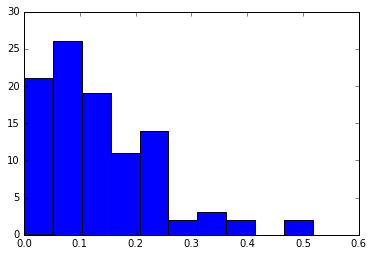

In [392]:
plt.hist(stack_perc[:,0],bins=10)

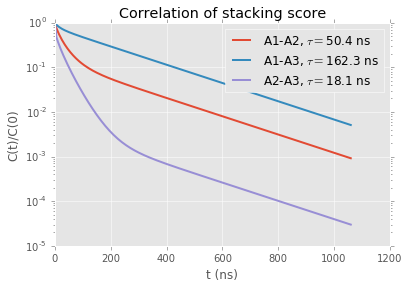

In [157]:
with plt.style.context(('ggplot')):
    kres=0
    for ires in range(3):
        for jres in range(ires+1,3):
            media_sq=np.dot(avg_stack_cl[:,kres],M.stationary_distribution)**2
            times,corr=M.correlation(avg_stack_cl[:,kres])
            acorr=(corr-media_sq)/(corr[0]-media_sq)
            t_corr=(0.5+np.sum(acorr[1:]))*M.lag/10
            plt.plot(times/10,acorr,lw=2,\
                     label=r'A%d-A%d, $\tau=$%.1f ns'%(ires+1,jres+1,t_corr))
            kres+=1
    plt.ylabel('C(t)/C(0)');plt.xlabel('t (ns)')
    plt.yscale('log')
    plt.legend()
    plt.title('Correlation of stacking score')
dire='/u/sbp/giopina/Dropbox/SISSA/markov/trino/'
name='trino-acorr'
#for ext in ['.pdf','.png','.svg','.eps']:
#        plt.savefig(dire+name+ext,dpi=200, bbox_inches='tight') 

In [158]:
#plt.plot(M.eigenvectors_left()[0,:],M.stationary_distribution,ls='',marker='.')
print M.eigenvectors_left()[1:,:].shape
print avg_stack_cl.shape
roba=np.tensordot(M.eigenvectors_left()[1:,:],avg_stack_cl,axes=[1,0])
print roba.shape
tau_a=np.sum( (roba**2)*M.timescales()[:,np.newaxis] ,axis=0)\
/np.sum(roba**2,axis=0)
print tau_a/10.

(99, 100)
(100, 3)
(99, 3)
[  50.43911764  163.27816034   17.41868926]


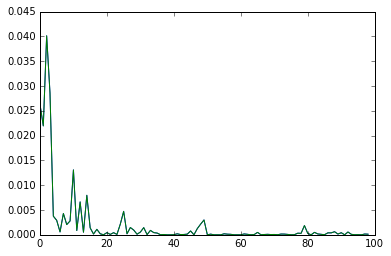

In [428]:
roba=np.tensordot(M.eigenvectors_left()[1:,:],avg_stack_cl,axes=[1,0])**2
ttt,aaa=M.fingerprint_correlation(avg_stack_cl[:,0])
#plt.plot(roba[:,0],aaa[1:],marker='.',ls='')
plt.plot(roba[:,0])
plt.plot(aaa[1:])

In [453]:
#evec_idx=np.arange(1,M.nstates)
evec_idx=np.arange(2,100)
roba=np.tensordot(M.eigenvectors_left()[evec_idx,:],avg_stack_cl,axes=[1,0])
tau_a=np.sum( (roba**2)*M.timescales()[evec_idx-1,np.newaxis] ,axis=0)\
/np.sum(roba**2,axis=0)
print '\nStacking autocorrelation times:\n'
print 'A1-A2 = %2.1f ns' % (tau_a[0]/10.)
print 'A1-A3 = %2.1f ns' % (tau_a[1]/10.)
print 'A2-A3 = %2.1f ns' % (tau_a[2]/10.)


Stacking autocorrelation times:

A1-A2 = 25.3 ns
A1-A3 = 18.1 ns
A2-A3 = 16.6 ns


In [434]:
#evec_idx=np.arange(1,M.nstates)
evec_idx=np.arange(1,100)
roba=np.tensordot(M.eigenvectors_left()[evec_idx,:],stack_perc,axes=[1,0])
tau_a=np.sum( (roba**2)*M.timescales()[evec_idx-1,np.newaxis] ,axis=0)\
/np.sum(roba**2,axis=0)
print '\nStack. perc. autocorrelation times:\n'
print 'A1-A2 = %2.1f ns' % (tau_a[0]/10.)
print 'A1-A3 = %2.1f ns' % (tau_a[1]/10.)
print 'A2-A3 = %2.1f ns' % (tau_a[2]/10.)


Stack. perc. autocorrelation times:

A1-A2 = 24.9 ns
A1-A3 = 45.6 ns
A2-A3 = 8.2 ns


In [452]:
evec_idx=np.arange(2,100)
ttt,rrr=M.fingerprint_correlation(np.sum(avg_stack_cl[:,:],axis=1))
np.sum( (rrr[evec_idx])*M.timescales()[evec_idx-1])\
/np.sum(rrr[evec_idx])/10

19.215175075565444

In [449]:
np.sum( (rrr[1:])*M.timescales()[evec_idx-1])\
/np.sum(rrr[1:])/10

50.439117635182306

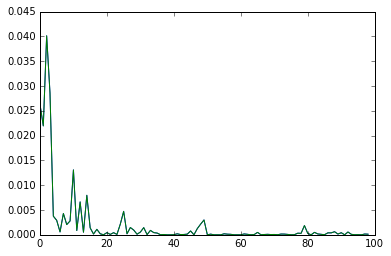

In [448]:
plt.plot(rrr[1:])
plt.plot(roba[:,0]**2)

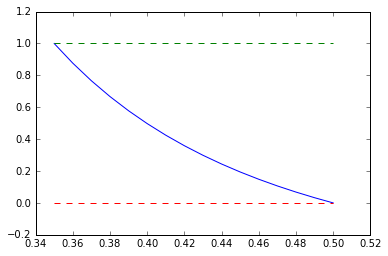

In [148]:
x=np.arange(0.35,0.5,0.01)
A=0.065258752
y=A/x**3-8*A
plt.plot(x,y)
plt.plot(x,np.ones(x.shape),ls='--')
plt.plot(x,np.zeros(x.shape),ls='--')

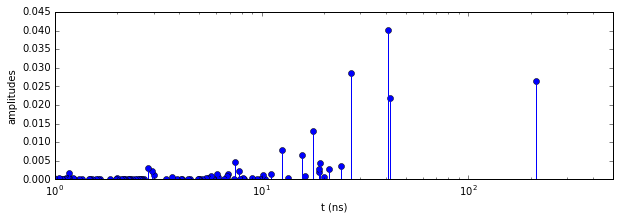

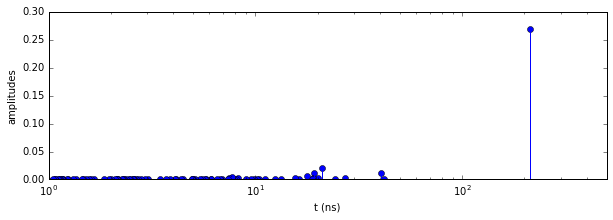

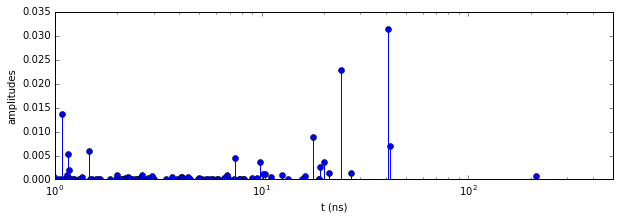

In [176]:
for kres in range(3):
    ttt,rrr=M.fingerprint_correlation(avg_stack_cl[:,kres])
    plt.figure(figsize=(10,3))
    plt.stem(ttt/10.,rrr,marker='o')
    plt.xscale('log')
    plt.xlabel('t (ns)')
    plt.ylabel('amplitudes')
    plt.xlim(1,500)

(1, 500)

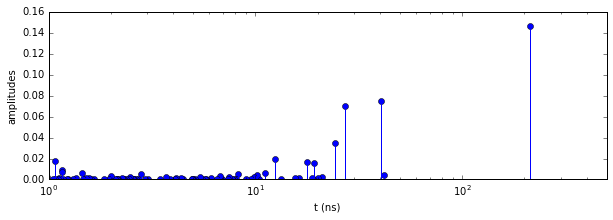

In [374]:
ttt,rrr=M.fingerprint_correlation(np.sum(avg_stack_cl,axis=1))
plt.figure(figsize=(10,3))
plt.stem(ttt/10.,rrr,marker='o')
plt.xscale('log')
plt.xlabel('t (ns)')
plt.ylabel('amplitudes')
plt.xlim(1,500)

In [381]:
evec_idx=np.arange(2,100)
tau_a=np.sum( rrr[evec_idx]*M.timescales()[evec_idx-1])\
/np.sum(rrr[evec_idx])
print tau_a/10

19.2151750756


# T-jump relaxation

In [212]:
# input files definitions
directo='/u/sbp/srnas1/giopina/run_GROMACS/trino/'
energyfiles=[directo+'run2/energy.xvg']
for idir in range(1,5):
    for irun in range(4):
        energyfiles.append(directo+'run_vari/'+\
                '/energy_'+str(idir)+'_'+str(irun)+'.xvg')
        #'dir'+str(idir)+'/run'+str(irun)\

In [217]:
ene_trajs=[]
for fname in energyfiles:
    etrj=[]
    for line in open(fname,'r'):
        if line[0]=='#':
            continue
        if line[0]=='@':
            continue
        etrj.append(float(line.split()[1]))
    ene_trajs.append(np.array(etrj[::20]))# why am I skipping the last one?

In [240]:
U_states=np.zeros(M.nstates)
U2_states=np.zeros(M.nstates)
NN=np.zeros(M.nstates)
for et,dt in zip(ene_trajs,M.discrete_trajectories_active):
    print et.shape,dt.shape
    for e,i in zip(et[:len(dt)],dt):
        if i<0: continue        
        U_states[i]+=e
        U2_states[i]+=e**2
        NN[i]+=1
U_states/=NN
U2_states/=NN
sigma_states=np.sqrt(U2_states-(U_states**2))/np.sqrt(NN)

(14002,) (14001,)
(34731,) (34731,)
(34731,) (34731,)
(34731,) (34731,)
(34731,) (34731,)
(34566,) (34565,)
(34566,) (34565,)
(34566,) (34565,)
(34566,) (34565,)
(34625,) (34625,)
(34625,) (34625,)
(34625,) (34625,)
(34625,) (34625,)
(35248,) (35248,)
(35248,) (35248,)
(35248,) (35248,)
(35248,) (35248,)


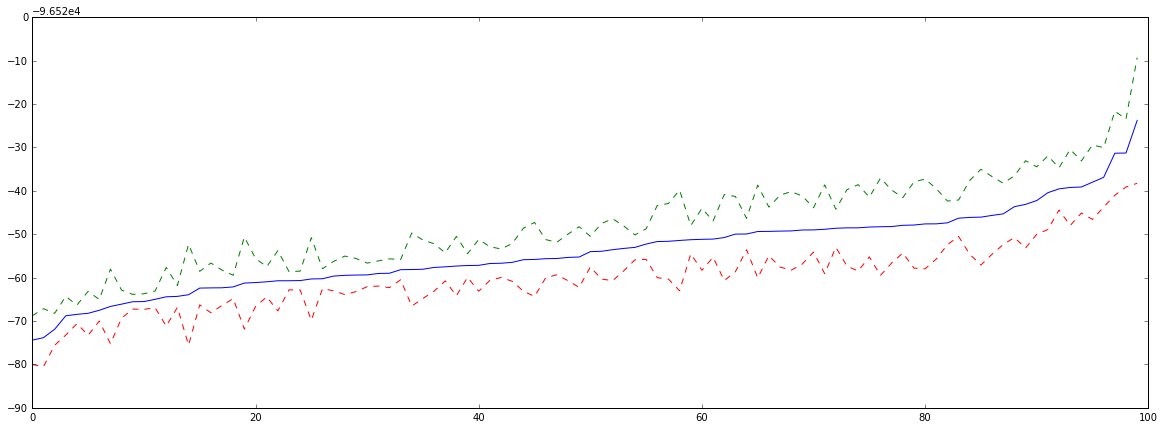

In [241]:
fig=plt.figure(figsize=(20,7))
order=np.argsort(U_states)
plt.plot(range(M.nstates),U_states[order])
plt.plot(range(M.nstates),U_states[order]+sigma_states[order],ls='--')
plt.plot(range(M.nstates),U_states[order]-sigma_states[order],ls='--')

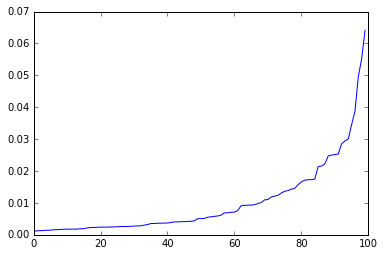

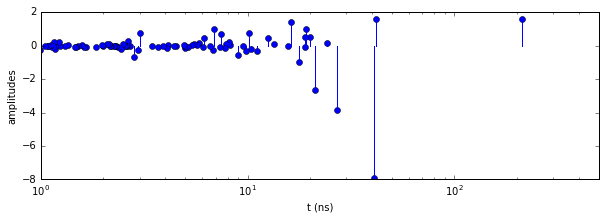

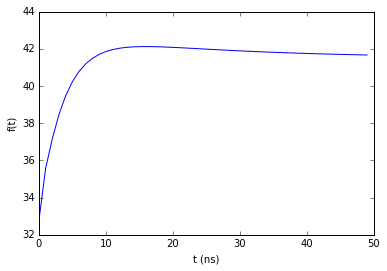

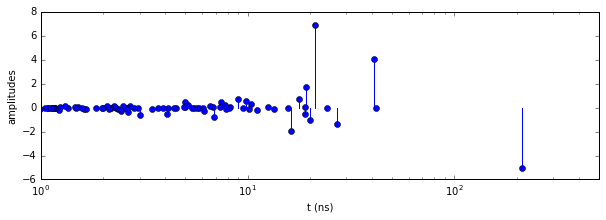

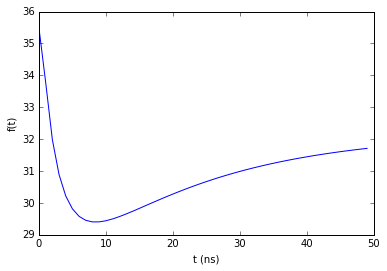

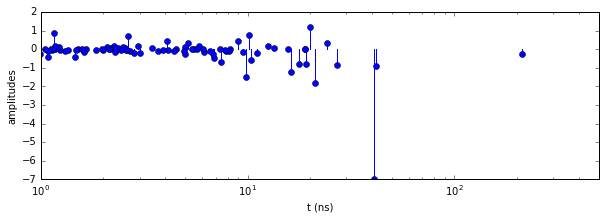

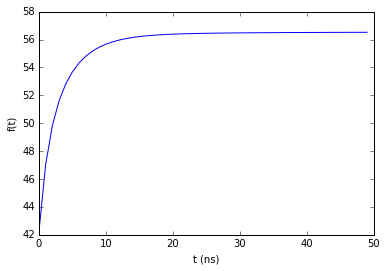

In [308]:
k_B_N_A=8.314
k_B = 1.380e-23 
N_A = 6.022e23
T0=295.
T1=300.
p0=M.stationary_distribution
fac=(T0-T1)*1000/k_B_N_A/T1/T0
#print fac
p1=p0*np.exp(-fac*U_states)
p1/=np.sum(p1)

#order=np.argsort(p0)
#plt.plot(np.sort(p0[order]))
#plt.plot(np.sort(p1[order]),color='red')

p1p=p1/p0

for kres in range(3):
    ttt,rrr=M.fingerprint_relaxation(p1p,avg_stack_cl[:,kres])
    plt.figure(figsize=(10,3))
    plt.stem(ttt/10.,rrr,marker='o')
    plt.xscale('log')
    plt.xlabel('t (ns)')
    plt.ylabel('amplitudes')
    plt.xlim(1,500)
    t=np.arange(0,50,1)
    ft=rrr[0]+np.tensordot( rrr[1:],np.exp(-t[np.newaxis,:]/(M.timescales()[:,np.newaxis]/100.)),\
                         axes=(0,0))
    plt.figure()
    plt.plot(t,ft)
    plt.xlabel('t (ns)')
    plt.ylabel('f(t)')

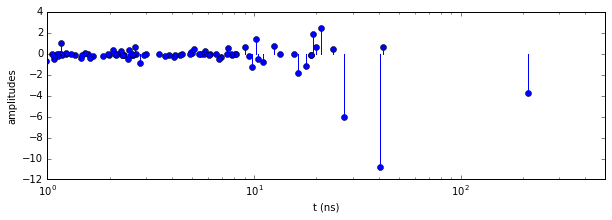

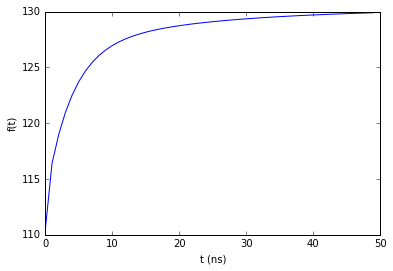

In [351]:
k_B_N_A=8.314
k_B = 1.380e-23 
N_A = 6.022e23
T0=295.
T1=300.
p0=M.stationary_distribution
fac=(T0-T1)*1000/k_B_N_A/T1/T0
#print fac
p1=p0*np.exp(-fac*U_states)
p1/=np.sum(p1)

#order=np.argsort(p0)
#plt.plot(np.sort(p0[order]))
#plt.plot(np.sort(p1[order]),color='red')

p1p=p1/p0

ttt,rrr=M.fingerprint_relaxation(p1p,np.sum(avg_stack_cl[:,:],axis=1))
plt.figure(figsize=(10,3))
plt.stem(ttt/10.,rrr,marker='o')
plt.xscale('log')
plt.xlabel('t (ns)')
plt.ylabel('amplitudes')
plt.xlim(1,500)
t=np.arange(0,50,1)
ft=rrr[0]+np.tensordot( rrr[1:],np.exp(-t[np.newaxis,:]/(M.timescales()[:,np.newaxis]/100.)),\
                         axes=(0,0))
plt.figure()
plt.plot(t,ft)
plt.xlabel('t (ns)')
plt.ylabel('f(t)')

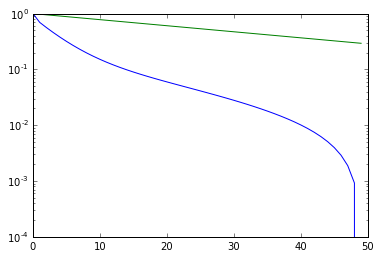

In [352]:
plt.plot(t,(ft[-1]-ft)/(ft[-1]-ft[0]))
plt.yscale('log')
plt.plot(t,np.exp(-t/40.))